In [1]:
import os 

#first put a shortcut in your drive to the image processing folder

RESULTS_DIR = os.path.join('/home',
                        'emily',
                        'Desktop',
                        'CAD',
                         'results' )


DATA_DIR = os.path.join('/home',
                        'emily',
                        'Desktop',
                        'CAD',
                        'challenge1')

print(os.listdir(RESULTS_DIR))

data_file = os.listdir(RESULTS_DIR)

['model_resnet50.pt', 'model_12_2.pt']


In [2]:
# import the required packages
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torch.utils.data as data
import copy

from torchmetrics import F1Score
from torchmetrics.functional import auroc
from torchmetrics.functional import precision_recall
from torchmetrics import AUROC

In [3]:
# hyperparameters
batch_size = 32
learning_rate = 0.02
epochs = 30
momentum = 0.1
lr_step_size = 1000   # if < epochs, we are using decaying learning rate
lr_gamma = 0.1
data_augmentation = True
dropout = 0.1
activation = nn.LeakyReLU()

# make visible only one GPU at the time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # <-- should be the ID of the GPU you want to use

# options
# device = "cuda:0"           # put here "cuda:0" if you want to run on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
monitor_display = True      # whether to display monitored performance plots
display_first_n = 0         # how many samples/batches are displayed
num_workers = 2             # how many workers (=threads) for fetching data
pretrained = False          # whether to test a pretrained model (to be loaded) or train a new one
display_errors = True       # whether to display errors (only in pretrained mode)
print(torch.cuda.is_available())

True


In [4]:
import torchvision.transforms.functional as TF
import random

random.seed(1)
# We need to use numpy for rotation transformation
# For sigma and mean we nee to do patch wise

# https://arxiv.org/pdf/2010.05351v1.pdf
class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, times, mode):
        self.times = times
        self.mode = mode

    def __call__(self, x):
        mode = random.choice(self.mode)
        if mode == 0:
          return np.fliplr(x)
        elif mode == 1:
          return np.flipud(x)
        else:   
          times = random.choice(self.times)
          return np.rot90(x, times)
# -90, 0, 90, and 180 degrees rotation

#rotation_transform = MyRotationTransform(angles=[-90, 0, 90, 180])
# pytorch transformations for augmentation https://arxiv.org/pdf/2010.05351v1.pdf
# DataAugmentation = transforms.RandomApply(
#         [ np.RandomHorizontalFlip(), 
#      transforms.RandomVerticalFlip(),
#      #transforms.RandomRotation(90, fill=(0,)),
#       MyRotationTransform(times=[1,2,3])] , p=0.5)  # fill=(0,) is a workaround for the torchvision bug tracked at https://github.com/pytorch/vision/issues/1759#issuecomment-575307516

class Convert(object):
    def __call__(self, img):
        return torch.unsqueeze(torch.from_numpy(img.astype('float')), 0).float()

transform_train = transforms.Compose(
    [MyRotationTransform(times=[1,2,3], mode=[0,1,2,3])]) 

# should randomly apply a transformation from the list

**Load information**

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Dataloader**

In [6]:
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

### **Model definition**

In [7]:
#from torchsummary import summary

import torchvision.models as models

NUM_CLASSES = 2

# pretrained efficient net b3
# https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b3.html#torchvision.models.efficientnet_b3
efficientb3 = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)

# https://stackoverflow.com/questions/68047331/how-to-add-the-last-classification-layer-in-efficienet-pre-trained-model-in-pyto
# efficientnet._fc = torch.nn.Linear(in_features = efficientb3._fc.in_features,
#                                   out_features = NUM_CLASSES,
#                                   bias = TRUE)

efficientb3.classifier[1] = torch.nn.Linear( in_features = efficientb3.classifier[1].in_features,
                                          out_features = NUM_CLASSES,
                                          bias = True)
#efficientb3.fc = nn.Linear(2048,2)

**Useful Metrics and Functions**

In [8]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [9]:
def save(model, path_to_save: str) -> None:
    torch.save(model.state_dict(), path_to_save)

def load(model, path_to_model: str):
    return model.load_state_dict(torch.load(path_to_model))

**Train and test function**

In [10]:
def train_model(model, dataloader, criterion, optimizer, scheduler, model_name, num_epochs=30, load_trained=False):
    # measure of time
    since = time.time()
    f1 = F1Score(num_classes=2).to(device)

    # load previous state of the model
    if load_trained:
      # if exist in here
      checkpoint = torch.load(RESULTS_DIR + model_name)
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      last_epoch = checkpoint['epoch']+1
      loss = checkpoint['loss']
    # restart
    else:
      last_epoch=0

    #It keeps track of the parameters of the model in certain state
    best_model_wts = copy.deepcopy(model.state_dict()) 
    best_auc = 0.0
  
    # start epoch
    for epoch in range(last_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)


        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
          
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
    
            f1_history = list()

            y_true = list()
            y_pred = list()


            tp_total = 0
            fp_total = 0
            tn_total = 0
            fn_total = 0 

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, dim=1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                f1_history.append(f1(preds, labels.data).double().cpu().numpy()) 
                y_true.append(labels.data.cpu())
                sig = nn.Sigmoid()
                y_pred.append(sig(outputs)[:,0].detach().cpu())

                # confusion matrix computation
                tp, fp, tn, fn = confusion(preds, labels.data)
                tp_total += tp
                fp_total += fp
                tn_total += tn
                fn_total += fn

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1 = np.mean(f1_history)
            epoch_auc = auroc(torch.cat(y_pred, dim=0), torch.cat(y_true, dim=0), max_fpr=0.0001).item()

            if phase == 'train':
              scheduler.step()
              torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                }, RESULTS_DIR+ model_name)  


            print('{} Loss: {:.4f} F1-score: {:.4f}'.format(
                phase, epoch_loss, epoch_f1))
            print('AUC: ', epoch_auc)
            
            # plot
            fig, ax1 = plt.subplots(figsize=(12,8), num=1)
            ax1.set_xticks(np.arange(0, epochs+1, step=epochs/10.0))
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel(type(criterion).__name__, color='blue')
            ax1.set_ylim(0.0001, 10)
            ax1.tick_params(axis='y', labelcolor='blue')
            ax1.set_yscale('log')
            ax1.plot(ticks, losses, 'b-', linewidth=1.0, aa=True, 
                label='Training (best at ep. %d)' % ticks[np.argmin(epoch_loss)])
            ax1.legend(loc="lower left")
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.set_ylabel('Accuracy %', color='red')
            ax2.set_ylim(50, 100)
            ax2.set_yticks(np.arange(50, 100, step=10))
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.plot(ticks, train_accuracies, 'r-', linewidth=1.0, aa=True, 
                label='Training (%.2f%%, best %.2f%% at ep. %d)' % (epoch_auc, max(train_accuracies), ticks[np.argmax(train_accuracies)]))
            ax2.plot(ticks, valid_accuracies, 'r--', linewidth=1.0, aa=True, 
                label='Validation (%.2f%%, best %.2f%% at ep. %d)' % (accuracy_valid, max(valid_accuracies), ticks[np.argmax(valid_accuracies)]))
            ax2.legend(loc="lower right")
            plt.xlim(0, epochs+1)
            # this works if running from notebooks
            if run_from_notebook:
                fig.show()
                fig.canvas.draw()
            # this works if running from console
            else:
                plt.draw()
                plt.pause(0.001)
            plt.savefig(experiment_ID + ".png", dpi=300)
            fig.clear()
            

            # deep copy the model if the performance improve
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())

            del f1_history, y_true, y_pred


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val auc: {:4f}'.format(best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
# define test function
# returns predictions
def test(dataset, dataloader):

    # switch to test mode
    net.eval()  

    # initialize predictions
    predictions = []
    reals = [] #torch.zeros(len(dataset), dtype=torch.int64)
    sample_counter = 0

    # do not accumulate gradients (faster)
    with torch.no_grad():

        # test all batches
        for inputs, labels in dataloader:

            # get data from dataloader [ignore labels/targets as they are not used in test mode]
            inputs = inputs.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = net(inputs)

            # store predictions
            outputs_max = torch.argmax(outputs, dim=1)
            predictions.append( outputs_max)
            reals.append(labels.data)
            sample_counter += 1 #We should look for MCC, AUC or F1-score, p-AUC- Ratio of positive negatives 10 - 4, 10-3

                #90 degrees rotations 1-100, 1-10

                #patch wise output into a set of regions
                #Using threshold
                #output probability map image processing

    return predictions, reals

**Model initialization and Training**

In [12]:
net = efficientb3.to(device) #we need to also send the model to the GPU as well

# create loss function
criterion = nn.CrossEntropyLoss() #most used for classification purposes

# create SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum) #most common optimizer is adam

# create learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

# experiment ID
experiment_ID = "%s_%s_%s_bs(%d)lr(%.4f_%d_%.1f)m(%.1f)e(%d)act(%s)xavier(yes)da(%s)do(%.1f)BN" % (type(net).__name__, type(criterion).__name__, type(optimizer).__name__,
                batch_size, learning_rate, lr_step_size, lr_gamma, momentum, epochs, type(activation).__name__, data_augmentation, dropout)

Epoch 1/30
----------
train Loss: 0.4870 F1-score: 0.7675
AUC:  0.4999749958515167


NameError: name 'ticks' is not defined

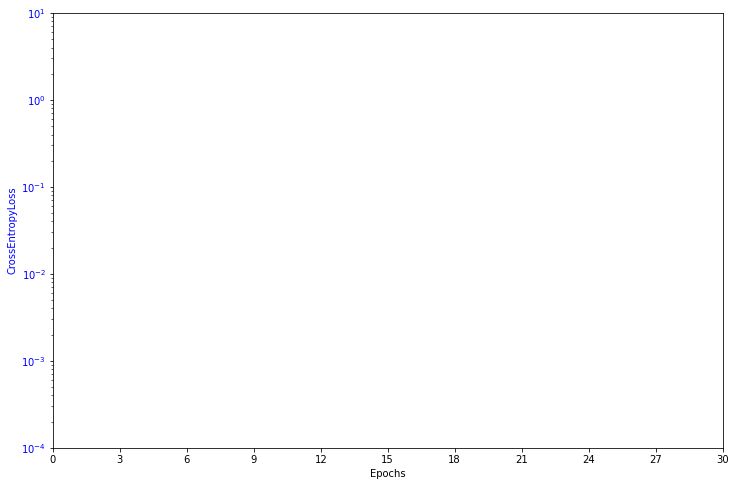

In [14]:
model = train_model(net, dataloaders, criterion, optimizer, scheduler, '/model_efficientb3.pt', num_epochs=epochs, load_trained=False)

In [ ]:
save(model, RESULTS_DIR+'/model_try1.pt')

## **Model Testing**

In [41]:
pip freeze

affine==2.3.1
appdirs==1.4.4
apturl==0.5.2
argon2-cffi==21.1.0
attrs==21.2.0
Babel==2.8.0
backcall==0.2.0
bcrypt==3.2.0
beautifulsoup4==4.10.0
beniget==0.4.1
bleach==4.1.0
blinker==1.4
Brlapi==0.8.3
Brotli==1.0.9
caffeine==2.9.8
certifi==2020.6.20
chardet==4.0.0
click==8.0.3
click-plugins==1.1.1
cligj==0.7.2
colorama==0.4.4
command-not-found==0.3
cryptography==3.4.8
cupshelpers==1.0
cycler==0.11.0
dbus-python==1.2.18
decorator==4.4.2
defer==1.0.6
defusedxml==0.7.1
distro==1.7.0
distro-info===1.1build1
duplicity==0.8.21
entrypoints==0.4
ewmh==0.1.6
fasteners==0.14.1
fonttools==4.29.1
fs==2.4.12
future==0.18.2
gast==0.5.2
html5lib==1.1
httplib2==0.20.2
idna==3.3
imageio==2.22.0
imbalanced-learn==0.9.1
imblearn==0.0
importlib-metadata==4.6.4
intensity-normalization==2.2.3
ipykernel==6.7.0
ipython==7.31.1
ipython_genutils==0.2.0
ipywidgets==6.0.0
jedi==0.18.0
jeepney==0.7.1
Jinja2==3.0.3
joblib==1.2.0
jsonschema==3.2.0
jupyter-client==7.1.2
jupyter-core==4.9.1
jupyterlab-pygments==0.1.2
ke

In [42]:
!pip freeze | grep pyTorch